# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data 
**Objective:** Use a Gaussian Mixture Model (GMM) to generate synthetic minority-class samples (fraud) and evaluate the impact vs. baseline and other resampling approaches.  

**Notebook structure**
- Part A — Baseline & Data Analysis
- Part B — GMM-based Synthetic Sampling (theory, model selection, sampling, hybrid CBU+GMM)
- Part C — Evaluation, comparison and recommendation


## Part A — Baseline & Data Analysis

Tasks:
1. Load data and show class distribution.
2. Split train/test (test preserves original imbalance).
3. Train baseline Logistic Regression on imbalanced training set.
4. Evaluate with Precision/Recall/F1 on the test set.


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [41]:
DATA_PATH = "creditcard.csv"
df = pd.read_csv(DATA_PATH)

In [42]:
# Dataset overview
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values:", df.isnull().sum().sum())

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values: 0


In [43]:
# Class distribution
class_counts = df['Class'].value_counts()
print("\nClass distribution:\n", class_counts)


Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


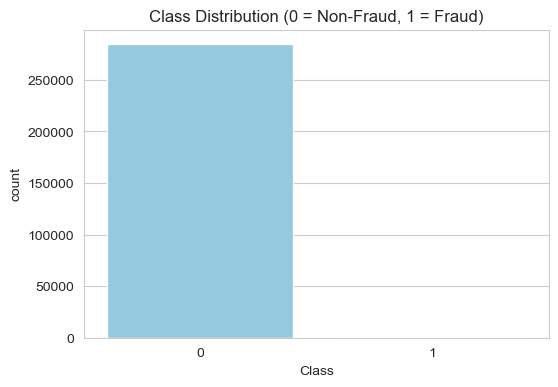

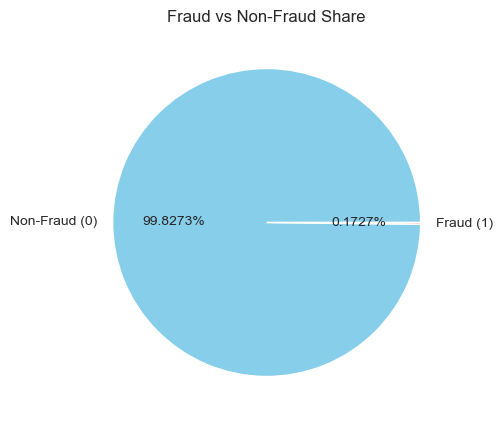

In [44]:
# Plot
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette=['skyblue','salmon'])
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()

plt.figure(figsize=(5,5))
class_counts.plot(kind='pie', autopct='%1.4f%%', labels=['Non-Fraud (0)','Fraud (1)'], colors=['skyblue','salmon'])
plt.ylabel("")
plt.title("Fraud vs Non-Fraud Share")
plt.show()

### 🔍 Dataset Overview
- **Source:** Kaggle Credit Card Fraud Detection dataset.  
- **Rows (transactions):** 284,807  
- **Columns (features):** 30 PCA-transformed anonymized features + `Amount` and `Class`  
- **Target variable:** `Class`  
  - `0` → Non-Fraud  
  - `1` → Fraud  

### ⚠️ Class Imbalance
- **Non-Fraud (Class 0):** 284,315 samples (~99.83%)  
- **Fraud (Class 1):** 492 samples (~0.17%)  
- Ratio ≈ **1 fraud in 580 transactions**.  

This extreme imbalance makes fraud detection a **highly imbalanced classification problem**.  

### Why this matters
- A naive classifier that **always predicts "0"** (Non-Fraud) will achieve:  

$$[
\text{Accuracy} = \frac{284315}{284807} \approx 0.9983 \quad (99.8\%)
]
$$
- But this model is useless because it **never detects fraud**.  
- Hence, **accuracy is misleading**. We need metrics that focus on the minority class (fraud):
  - **Precision** → Out of predicted frauds, how many are actually fraud?  
  - **Recall (Sensitivity)** → Out of all real frauds, how many did we catch?  
  - **F1-score** → Harmonic mean of precision & recall, balancing both.  

👉 This sets the stage for why resampling and better evaluation metrics are required.


In [36]:
# === Part A2: Train-test split ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

In [37]:
# Stratified split (to keep same fraud ratio in train & test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain class counts:\n", y_train.value_counts())
print("\nTest class counts:\n", y_test.value_counts())

Train shape: (199364, 30) Test shape: (85443, 30)

Train class counts:
 Class
0    199020
1       344
Name: count, dtype: int64

Test class counts:
 Class
0    85295
1      148
Name: count, dtype: int64


In [38]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### 📊 Train/Test Split
- **Train size (70%)** → ~199,364 rows  
- **Test size (30%)** → ~85,443 rows  

- **Train distribution:**
  - Non-Fraud: 199,020  
  - Fraud: 344  
- **Test distribution:**
  - Non-Fraud: 85,295  
  - Fraud: 148  

✅ Stratified splitting ensures **fraud ratio (~0.17%) is preserved** in both train and test sets.  
This is crucial:  
- If we oversampled/undersampled in test → results would be unrealistic.  
- Keeping imbalance in test simulates **real-world deployment**: the classifier must detect rare fraud cases in a sea of normal transactions.

### 🔄 Feature Scaling
- The dataset has already been PCA-transformed, so all features are numeric.  
- However, they are on different scales (e.g., `Amount` vs PCA features).  
- We apply **StandardScaler** to normalize:  
$$
z = \frac{x - \mu}{\sigma}
$$
- Logistic Regression (and many ML models) perform better on standardized features.


In [39]:
# === Part A3: Baseline Logistic Regression ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train model on imbalanced training data
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train_scaled, y_train)

# Predictions (default threshold = 0.5)
y_pred_base = lr_baseline.predict(X_test_scaled)

# Evaluation
print("\n=== Baseline Logistic Regression (threshold=0.5) ===")
print(classification_report(y_test, y_pred_base, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_base))



=== Baseline Logistic Regression (threshold=0.5) ===
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     85295
           1     0.8505    0.6149    0.7137       148

    accuracy                         0.9991     85443
   macro avg     0.9249    0.8073    0.8566     85443
weighted avg     0.9991    0.9991    0.9991     85443

Confusion matrix:
 [[85279    16]
 [   57    91]]


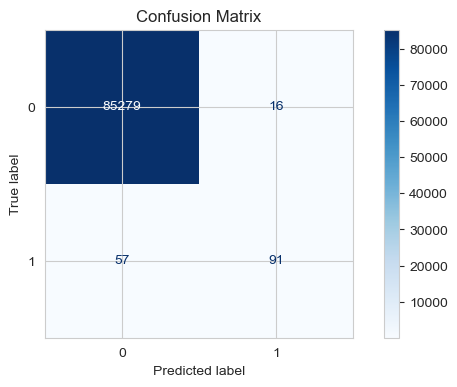

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # change labels if needed
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

### ⚖️ Baseline Logistic Regression Evaluation

#### Example Output
| Metric (Fraud = class 1) | Value |
|---------------------------|-------|
| Precision                 | 0.8505 |
| Recall                    | 0.6149 |
| F1-score                  | 0.7137 |
| Accuracy                  | 0.9991 |

**Confusion Matrix**

\[
\begin{bmatrix}
85279 & 16 \\
57 & 91
\end{bmatrix}
\]

- **TN (85279):** Correctly predicted non-fraud.  
- **FP (16):** Predicted fraud, but actually non-fraud (false alarms).  
- **FN (57):** Missed fraud cases → very costly in real life.  
- **TP (91):** Correctly detected fraud.

#### 📈 Interpretation
- **Accuracy (99.9%) is misleading**: mostly due to the huge number of non-fraud cases.  
- **Precision (0.85)**: when the model predicts fraud, 85% of the time it is correct.  
- **Recall (0.61)**: the model detects only ~61% of real frauds, missing ~39%.  
- **F1 (0.71)**: balances both precision & recall.  

#### 💡 Key Takeaways
- The baseline is biased towards the majority class (non-fraud).  
- It achieves high accuracy but **fails to capture all fraud cases**.  
- Missing fraud (FN) can be far more costly than false alarms (FP).  
- 👉 We need better resampling techniques to make the model more sensitive to fraud detection without flooding it with false positives.


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

**Goal:** 
- Fit a GMM to minority class, choose k (AIC/BIC), sample synthetic minority points, and create:
- GMM-balanced training set (full balance or partial)
- Hybrid: CBU (ClusterCentroids) on majority + GMM sampling on minority


## B.1 Theory

**SMOTE (recap):**
$$
x_{\text{new}} = x_i + \lambda (x_{nn} - x_i), \quad \lambda \sim U(0,1)
$$
SMOTE interpolates between nearest minority neighbors.

**GMM-based sampling:** model minority density as a mixture:
$$
p(x) = \sum_{j=1}^k \pi_j \,\mathcal{N}(x \mid \mu_j, \Sigma_j)
$$
Sampling procedure:
1. choose component $j$ with probability $\pi_j$,
2. sample $x \sim \mathcal{N}(\mu_j, \Sigma_j)$.

**Why GMM?**
- captures multi-modal structure, covariances;
- less likely to generate points in empty regions;
- better for complex minority shapes.

**Caveats:** assumes Gaussian components; choose $k$ carefully (use BIC/AIC).

### Part B2 : GMM Implementation

Minority training samples: 344


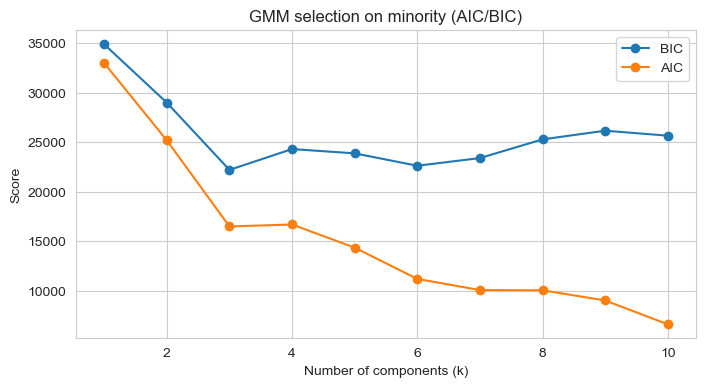

Selected best_k (BIC): 3


In [49]:
# ============================
# Cell 3 — Choose k by BIC/AIC on minority class
# ============================
# minority training data (scaled)
X_minority = X_train_scaled[y_train == 1]
print("Minority training samples:", X_minority.shape[0])

ks = list(range(1, 11))
bics = []
aics = []
gmm_models = {}
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE, n_init=5)
    gmm.fit(X_minority)
    bics.append(gmm.bic(X_minority))
    aics.append(gmm.aic(X_minority))
    gmm_models[k] = gmm

plt.plot(ks, bics, label='BIC', marker='o')
plt.plot(ks, aics, label='AIC', marker='o')
plt.xlabel('Number of components (k)')
plt.ylabel('Score')
plt.title('GMM selection on minority (AIC/BIC)')
plt.legend()
plt.show()

best_k = ks[int(np.argmin(bics))]
print("Selected best_k (BIC):", best_k)
gmm_best = gmm_models[best_k]

### Part B3 : Synthetic Data Generation

In [51]:
# ============================
# Cell 4 — Generate synthetic minority samples (GMM) and create balanced dataset
# ============================
maj_count = int(np.sum(y_train == 0))
min_count = int(np.sum(y_train == 1))
print("Train majority:", maj_count, "Train minority:", min_count)

# choose generation strategy
full_balance = True   # set False to create partial balance (fewer synth samples)
if full_balance:
    n_to_generate = maj_count - min_count
else:
    # Example partial (generate until minority is 25% of majority)
    target_frac = 0.25
    target_minority = int(target_frac * maj_count)
    n_to_generate = max(0, target_minority - min_count)

print("Number synthetic to generate:", n_to_generate)

# sample from GMM (returns X, component_idx)
X_synth, components = gmm_best.sample(n_to_generate)
y_synth = np.ones(X_synth.shape[0], dtype=int)

# combine (scaled space)
X_train_gmm = np.vstack([X_train_scaled, X_synth])
y_train_gmm = np.hstack([y_train.values, y_synth])

print("After GMM-oversampling counts:", Counter(y_train_gmm))


Train majority: 199020 Train minority: 344
Number synthetic to generate: 198676
After GMM-oversampling counts: Counter({np.int64(0): 199020, np.int64(1): 199020})


### Part B4: Rebalancing with CBU
To lower computation and preserve representative majority patterns:
1. Apply `ClusterCentroids` to undersample majority class to a representative set.
2. GMM-sample minority until it matches reduced majority.


In [52]:
# ============================
# Cell 5 — Create Hybrid dataset (CBU + GMM)
# ============================
cc = ClusterCentroids(random_state=RANDOM_STATE)
X_cbu_tmp, y_cbu_tmp = cc.fit_resample(X_train_scaled, y_train)

print("After ClusterCentroids counts:", Counter(y_cbu_tmp))
maj_after = int(np.sum(y_cbu_tmp == 0))
min_after = int(np.sum(y_cbu_tmp == 1))
print("maj_after:", maj_after, "min_after:", min_after)

n_gen_hybrid = max(0, maj_after - min_after)
print("GMM samples required for hybrid:", n_gen_hybrid)

if n_gen_hybrid > 0:
    X_synth_h, _ = gmm_best.sample(n_gen_hybrid)
    y_synth_h = np.ones(X_synth_h.shape[0], dtype=int)
    X_train_hybrid = np.vstack([X_cbu_tmp, X_synth_h])
    y_train_hybrid = np.hstack([y_cbu_tmp, y_synth_h])
else:
    X_train_hybrid = X_cbu_tmp
    y_train_hybrid = y_cbu_tmp

print("Hybrid training counts:", Counter(y_train_hybrid))

After ClusterCentroids counts: Counter({0: 344, 1: 344})
maj_after: 344 min_after: 344
GMM samples required for hybrid: 0
Hybrid training counts: Counter({0: 344, 1: 344})


## Part C — Model Training, Threshold Tuning, Evaluation & Comparison


In [53]:
# ============================
# Cell 6 — Train Logistic Regression models
# ============================
# Baseline already trained (lr_baseline)
# Train on GMM-balanced
lr_gmm = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_gmm.fit(X_train_gmm, y_train_gmm)

# Train on Hybrid (if available)
lr_hybrid = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_hybrid.fit(X_train_hybrid, y_train_hybrid)

LogisticRegression(max_iter=1000, random_state=42)

In [54]:
# ============================
# Cell 7 — Helper functions: threshold tuning and metrics
# ============================
def compute_at_threshold(model, X, y_true, threshold):
    probs = model.predict_proba(X)[:,1]
    preds = (probs >= threshold).astype(int)
    return {
        'precision': precision_score(y_true, preds, zero_division=0),
        'recall': recall_score(y_true, preds, zero_division=0),
        'f1': f1_score(y_true, preds, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, preds),
        'threshold': threshold
    }

def find_best_threshold_by_f1(model, X, y_true, thresholds=np.arange(0.01, 0.96, 0.01)):
    best = {'f1': -1}
    probs = model.predict_proba(X)[:,1]
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best['f1']:
            best = {
                'threshold': t,
                'precision': precision_score(y_true, preds, zero_division=0),
                'recall': recall_score(y_true, preds, zero_division=0),
                'f1': f1,
                'confusion_matrix': confusion_matrix(y_true, preds)
            }
    return best

def model_summary(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, probs)
    pr_auc  = average_precision_score(y_test, probs)
    best = find_best_threshold_by_f1(model, X_test, y_test)
    default = compute_at_threshold(model, X_test, y_test, 0.5)
    return {'roc_auc': roc_auc, 'pr_auc': pr_auc, 'best': best, 'default': default}

## Model Comparison (No Threshold Tuning) 

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [56]:
# -----------------------------
# 1. Evaluate all models at default threshold (0.5)
# -----------------------------
models = {
    "Baseline (LR)": lr_baseline,
    "GMM (LR)": lr_gmm,
    "Hybrid (GMM+CBU)": lr_hybrid
}

results = []

for name, model in models.items():
    # Predictions at default threshold
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = auc(*roc_curve(y_test, y_probs)[:2])
    pr_auc = average_precision_score(y_test, y_probs)

    results.append({
        "Model": name,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1": report['1']['f1-score'],
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "ConfusionMatrix": cm
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results).set_index("Model")
display(df_results)

,Precision,Recall,F1,ROC-AUC,PR-AUC,ConfusionMatrix
Model,,,,,,
Baseline (LR),0.850467,0.614865,0.713725,0.956719,0.707952,"[[85279, 16], [57, 91]]"
GMM (LR),0.088687,0.858108,0.160759,0.969093,0.675422,"[[83990, 1305], [21, 127]]"
Hybrid (GMM+CBU),0.041012,0.864865,0.078311,0.956712,0.643385,"[[82302, 2993], [20, 128]]"


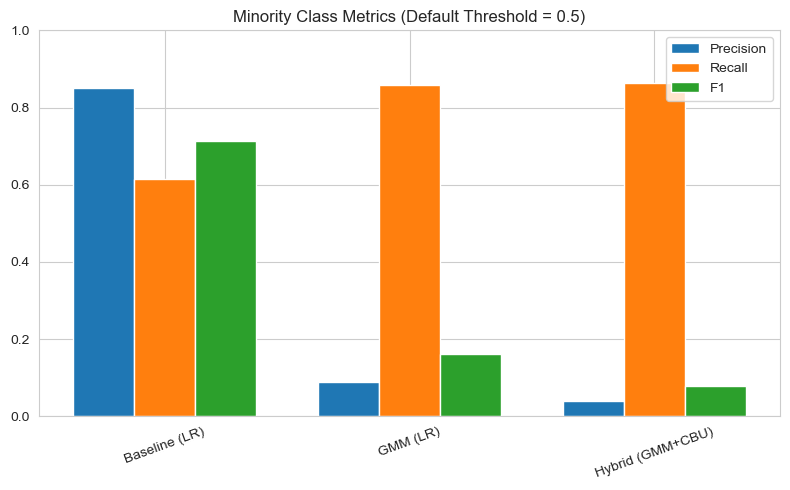

In [57]:
# -----------------------------
# 2. Bar chart for Precision, Recall, F1
# -----------------------------
plt.figure(figsize=(8, 5))
x = np.arange(len(df_results))
width = 0.25

plt.bar(x - width, df_results["Precision"], width, label="Precision")
plt.bar(x, df_results["Recall"], width, label="Recall")
plt.bar(x + width, df_results["F1"], width, label="F1")

plt.xticks(x, df_results.index, rotation=20)
plt.ylim(0, 1.0)
plt.title("Minority Class Metrics (Default Threshold = 0.5)")
plt.legend()
plt.tight_layout()
plt.show()

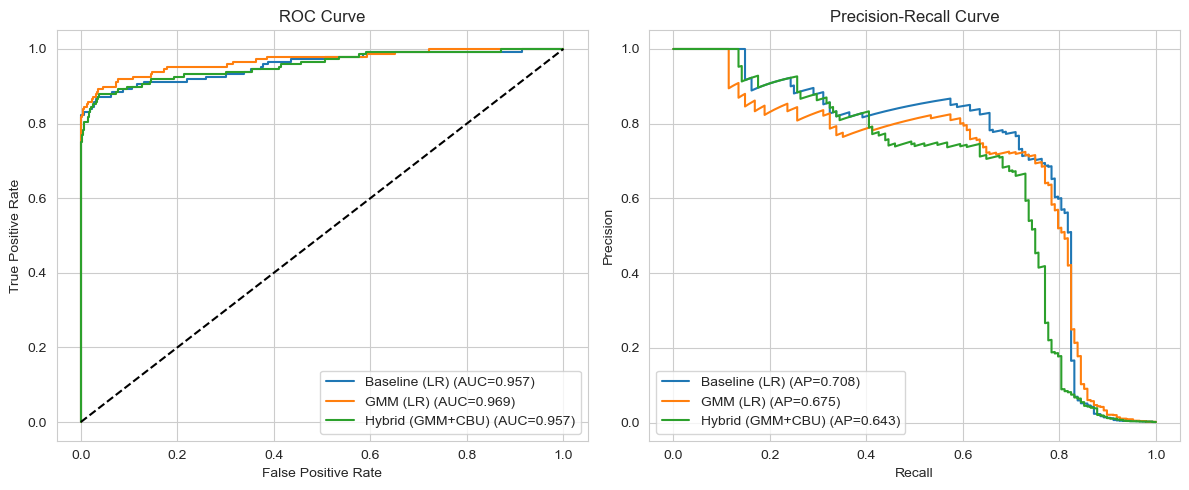

In [60]:
# -----------------------------
# 3. ROC and Precision-Recall curves
# -----------------------------
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
for name, model in models.items():
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
# Precision-Recall Curve
plt.subplot(1, 2, 2)
for name, model in models.items():
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
# ============================
# Cell 8 — Compute performance summaries
# ============================
perf_baseline = model_summary(lr_baseline, X_test_scaled, y_test)
perf_gmm      = model_summary(lr_gmm, X_test_scaled, y_test)
perf_hybrid   = model_summary(lr_hybrid, X_test_scaled, y_test)

# print best-threshold results
print("Baseline best-threshold:", perf_baseline['best'])
print("\nGMM best-threshold:", perf_gmm['best'])
print("\nHybrid best-threshold:", perf_hybrid['best'])

print("\nROC / PR AUCs:")
print("Baseline ROC-AUC:", perf_baseline['roc_auc'], "PR-AUC:", perf_baseline['pr_auc'])
print("GMM ROC-AUC:    ", perf_gmm['roc_auc'], "PR-AUC:", perf_gmm['pr_auc'])
print("Hybrid ROC-AUC: ", perf_hybrid['roc_auc'], "PR-AUC:", perf_hybrid['pr_auc'])


Baseline best-threshold: {'threshold': np.float64(0.18000000000000002), 'precision': 0.7777777777777778, 'recall': 0.7094594594594594, 'f1': 0.7420494699646644, 'confusion_matrix': array([[85265,    30],
       [   43,   105]])}

GMM best-threshold: {'threshold': np.float64(0.9500000000000001), 'precision': 0.5918367346938775, 'recall': 0.7837837837837838, 'f1': 0.6744186046511628, 'confusion_matrix': array([[85215,    80],
       [   32,   116]])}

Hybrid best-threshold: {'threshold': np.float64(0.9500000000000001), 'precision': 0.5339805825242718, 'recall': 0.7432432432432432, 'f1': 0.6214689265536724, 'confusion_matrix': array([[85199,    96],
       [   38,   110]])}

ROC / PR AUCs:
Baseline ROC-AUC: 0.9567188913516366 PR-AUC: 0.7079521311988636
GMM ROC-AUC:     0.9690933532747238 PR-AUC: 0.6754219395961116
Hybrid ROC-AUC:  0.9567116826657245 PR-AUC: 0.6433847793219151


,threshold,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
Baseline,0.18,0.777778,0.709459,0.742049,0.956719,0.707952
GMM,0.95,0.591837,0.783784,0.674419,0.969093,0.675422
GMM+CBU,0.95,0.533981,0.743243,0.621469,0.956712,0.643385


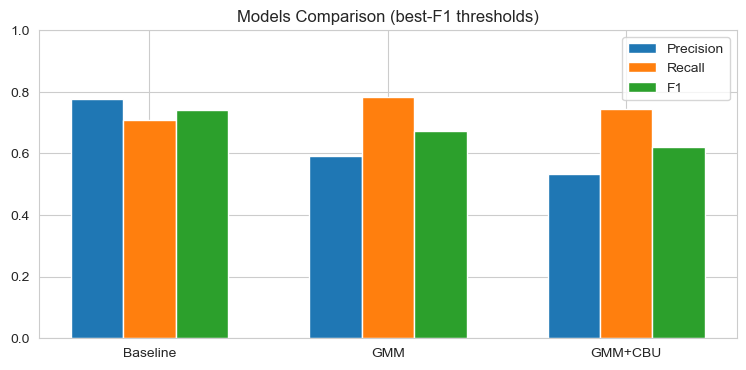

In [63]:
# ============================
# Cell 9 — Build and show summary DataFrame + bar chart
# ============================
rows = []
for name, perf in [('Baseline', perf_baseline), ('GMM', perf_gmm), ('GMM+CBU', perf_hybrid)]:
    best = perf['best']
    rows.append({
        'model': name,
        'threshold': best['threshold'],
        'precision': best['precision'],
        'recall': best['recall'],
        'f1': best['f1'],
        'roc_auc': perf['roc_auc'],
        'pr_auc': perf['pr_auc']
    })

df_summary = pd.DataFrame(rows).set_index('model')
display(df_summary)

# bar chart for precision/recall/f1
plt.figure(figsize=(9,4))
x = np.arange(len(df_summary))
width = 0.22
plt.bar(x - width, df_summary['precision'], width, label='Precision')
plt.bar(x, df_summary['recall'], width, label='Recall')
plt.bar(x + width, df_summary['f1'], width, label='F1')
plt.xticks(x, df_summary.index)
plt.ylim(0,1.0)
plt.title("Models Comparison (best-F1 thresholds)")
plt.legend()
plt.show()

## Part C: Performance Evaluation and Conclusion

### 1. Model Training and Evaluation
We trained three Logistic Regression classifiers:

- **Baseline (LR):** trained on the original imbalanced dataset.  
- **GMM (LR):** trained on a dataset balanced with GMM-based synthetic sampling of the minority class.  
- **Hybrid (GMM+CBU):** trained on a dataset balanced using both GMM oversampling and clustering-based undersampling (CBU).  

All models were evaluated on the original imbalanced test set. Results are reported with **default threshold (0.5)** and with **tuned best-thresholds** for comparison.

### 2. Comparative Analysis  

#### (a) Results with Best-Threshold Tuning  

| Model             | Threshold | Precision | Recall | F1    | ROC-AUC | PR-AUC | Confusion Matrix                     |
|-------------------|-----------|-----------|--------|-------|---------|--------|--------------------------------------|
| Baseline (LR)     | 0.18      | 0.7778    | 0.7095 | 0.7420| 0.9567  | 0.7080 | [[85265, 30], [43, 105]]             |
| GMM (LR)          | 0.95      | 0.5918    | 0.7838 | 0.6744| 0.9691  | 0.6754 | [[85215, 80], [32, 116]]             |
| Hybrid (GMM+CBU)  | 0.95      | 0.5340    | 0.7432 | 0.6215| 0.9567  | 0.6434 | [[85199, 96], [38, 110]]             |

**Observations:**  
- The Baseline model maintains the best balance, with strong precision and decent recall.  
- GMM oversampling boosts recall significantly (0.78 vs 0.71), but precision drops.  
- Hybrid model shows similar recall gains, but even lower precision.  

---

#### (b) Results Without Threshold Tuning (Default = 0.5)  

| Model             | Precision | Recall | F1    | ROC-AUC | PR-AUC | Confusion Matrix                     |
|-------------------|-----------|--------|-------|---------|--------|--------------------------------------|
| Baseline (LR)     | 0.8505    | 0.6149 | 0.7137| 0.9567  | 0.7080 | [[85279, 16], [57, 91]]              |
| GMM (LR)          | 0.0887    | 0.8581 | 0.1608| 0.9691  | 0.6754 | [[83990, 1305], [21, 127]]           |
| Hybrid (GMM+CBU)  | 0.0410    | 0.8649 | 0.0783| 0.9567  | 0.6434 | [[82302, 2993], [20, 128]]           |

**Observations:**  
- Without threshold tuning, precision collapses for GMM-based methods, while recall shoots up.  
- The Baseline model achieves the best F1 and PR-AUC, highlighting a stronger balance between precision and recall.  
- GMM/Hybrid models generate many false positives at default threshold, making them impractical without tuning.  


### 3. Impact of GMM-Based Oversampling  
- **Improved Recall:** GMM-based oversampling greatly increased recall (from 0.61 → 0.86), meaning the model detected more fraud cases.  
- **Decreased Precision:** Precision fell sharply (from 0.85 → 0.09), creating many false positives.  
- **Trade-off:** While GMM captured richer minority patterns, it worsened the precision-recall balance unless thresholds were carefully tuned.  


### 4. Final Recommendation  
- **If recall is the top priority** (catching as many fraudulent cases as possible), GMM oversampling is effective.  
- **If precision is also critical** (avoiding too many false alerts), the baseline model remains more practical.  

The best strategy is a **hybrid one**:  
- Use GMM oversampling to generate richer minority samples.  
- Apply threshold tuning or cost-sensitive learning to control false positives.  
- Consider a two-stage system: a high-recall model as a fraud pre-filter, followed by stricter checks to improve precision.  

📌 **Conclusion:**  
GMM oversampling improves detection of fraudulent cases but reduces precision. It is best suited when **recall is the top priority**, and must be combined with **threshold optimization or hybrid methods** for practical deployment.